In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib import cm
import seaborn as sns
import glob
import pickle
from collections import defaultdict
from Bio.Seq import Seq
import ete3
import os

import utils.trees

## Load GC trees

In [2]:
results = "../nextflow/results/"
ranking_subdir = 'naive_reversions_first'

metadata_csv = "../gc_metadata.csv"

mutability_csv = "../nextflow/data/mutability/MK_RS5NF_mutability.csv"
substitution_csv = "../nextflow/data/mutability/MK_RS5NF_substitution.csv"
# chigy_hc_mut_rates = "../passenger/output/chigy_hc_mutation_rates_nt.csv"
# chigy_lc_mut_rates = "../passenger/output/chigy_lc_mutation_rates_nt.csv"

final_variant_scores = "data/dms/final_variant_scores.csv"
dms_sites = "data/dms/CGGnaive_sites.csv"

outbase = "output/phenotype-trajectories"
workflow_env_exec = False # only set to True within the Nextflow papermill process

In [3]:
output_dir = f"{outbase}/{ranking_subdir}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
metadata = pd.read_csv(metadata_csv, index_col=0)
metadata.query("(strain == 'wt') & (cell_type == 'GC') & (imm_duration != 'w10')", inplace=True)
metadata.rename(columns={'imm_duration': 'time'}, inplace=True)
metadata

,ngs_id,time,mouse,gc,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col
uid,,,,,,,,,,,,
D15_M1_GC1,PR-2-01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC2,PR-2-01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC3,PR-2-01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M2_GC4,PR-2-01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M3_GC5,PR-2-01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
...,...,...,...,...,...,...,...,...,...,...,...,...
D20_M24_GC115,PR-1-04,d20,24,115,wt,RP,GC,72,16,16,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D20_M25_GC116,PR-1-02,d20,25,116,wt,RP,GC,65,8,8,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D20_M25_GC117,PR-1-03,d20,25,117,wt,RP,GC,68,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12


In [5]:
trees = utils.trees.load_trees(metadata, results, ranking_subdir)
len(trees)

119

## Mutability model

In [6]:
mutability = pd.read_csv(mutability_csv, sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv(substitution_csv, sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igh_frame = 1
igk_frame = 1
igk_idx = 336

def mutate_uniform(sequence):
    i = np.random.choice(len(sequence))
    base = sequence[i]
    alt_base = np.random.choice(list("ACGT".replace(base, "")))
    sequence = list(sequence)
    sequence[i] = alt_base
    return "".join(sequence)

def mutate_S5F(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

naive_igh_aa = aa(naive[:igk_idx], igh_frame)
naive_igk_aa = aa(naive[igk_idx:], igk_frame)

## DMS data

In [7]:
dms_df = pd.read_csv(final_variant_scores, index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr,WT,site
mutation,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,8.74239,0.11933,20,2,10.45318,-0.00246,20,2,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,8.60813,-0.01492,22,2,10.33348,-0.12216,22,2,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,8.63554,0.01249,18,2,10.50438,0.04874,18,2,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,8.62305,0.00000,23285,2,10.45565,0.00000,23285,2,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,8.75738,0.13433,29,2,10.34185,-0.11379,29,2,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,8.63400,0.01095,45,2,10.52908,0.07344,45,2,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,8.64386,0.02081,41,2,10.54211,0.08647,41,2,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,8.58887,-0.03418,28,2,10.49638,0.04073,28,2,False,L-128


In [8]:
pos_df = pd.read_csv(dms_sites, dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [9]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Simulate expression-matched trees

This cell takes a while (~1 hour)

In [10]:
# sim_trees = defaultdict(list)
# expression_threshold = 0.2
# n_replicates = 2
# for gc, tree in trees.items():
#     replicate = 1
#     dead = False
#     while replicate <= n_replicates:
#         print(f"GC {gc} replicate {replicate}", end="   \r")
#         new_tree = tree.tree.copy()
#         for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
#             assert node.name == node_new.name
#             if not node.is_root():
#                 success = False
#                 closest = np.inf
#                 for tries in range(100):
#                     node_new.sequence = node_new.up.sequence
#                     for _ in range(int(node.dist)):
#                         node_new.sequence = mutate_S5F(node_new.sequence)
#                         igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
#                         igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
#                         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
#                         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
#                         all_mutations = igh_mutations + igk_mutations
#                         if any("*" in x for x in all_mutations):
#                             node_new.delta_bind_CGG = None
#                             node_new.delta_expr = None
#                         else:
#                             node_new.delta_bind_CGG = dms_df.delta_bind_CGG[all_mutations].sum()
#                             node_new.delta_expr = dms_df.delta_expr[all_mutations].sum()
#                     # note: selecting on additive expression estimate
#                     if node_new.delta_expr is None:
#                         continue
#                     delta = np.abs(node_new.delta_expr - node.delta_expr)
#                     if delta < closest:
#                         closest = delta
#                         closest_seq = node_new.sequence
#                         delta_bind_CGG = node_new.delta_bind_CGG
#                         closest_delta_expr = node_new.delta_expr
#                     if delta < expression_threshold:
#                         success = True
#                         break
#                 if not success:
#                     node_new.sequence = closest_seq
#                     node_new.delta_bind_CGG = delta_bind_CGG
#                     node_new.delta_expr = closest_delta_expr

#         sim_trees[gc].append(new_tree)
#         replicate += 1

Faster version is simply linear trajectories (no tree)

In [11]:
sim_df = pd.DataFrame()
# expression_thresh = -1
expression_thresh = -np.inf
replicate = 1
while replicate < 1000:
    print(f"replicate {replicate + 1}", end="   \r")
    sequence = naive
    n_mutations = 0
    rows = []
    while n_mutations <= 20:
        if n_mutations:
            new_sequence = mutate_S5F(sequence)
        else:
            new_sequence = sequence
        igh_aa = aa(new_sequence[:igk_idx], igh_frame)
        igk_aa = aa(new_sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
        all_mutations = igh_mutations + igk_mutations
        has_stop = any("*" in mutation for mutation in all_mutations)
        affinity = np.nan if has_stop else dms_df.delta_bind_CGG[all_mutations].sum()
        expression = np.nan if has_stop else dms_df.delta_expr[all_mutations].sum()
        if expression < expression_thresh:
            continue
        new_row = [affinity,
                   expression,
                   n_mutations,
                   replicate,
                  ]
        rows.append(new_row)
        sequence = new_sequence
        n_mutations += 1
    rep_df = pd.DataFrame(rows, columns=(r"$\Delta$ affinity", r"$\Delta$ expression", "divergence", "replicate"))
    sim_df = pd.concat((sim_df, rep_df), ignore_index=True, verify_integrity=True)
    replicate += 1
sim_df

,$\Delta$ affinity,$\Delta$ expression,divergence,replicate
0,0.00000,0.00000,0,1
1,-0.01687,0.02167,1,1
2,-0.04432,0.05370,2,1
3,NaN,NaN,3,1
4,NaN,NaN,4,1
...,...,...,...,...
20974,NaN,NaN,16,999
20975,NaN,NaN,17,999
20976,NaN,NaN,18,999
20977,NaN,NaN,19,999


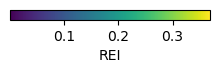

In [12]:
vmin = min(node.REI for tree in trees.values() for node in tree.tree.traverse())
vmax = max(node.REI for tree in trees.values() for node in tree.tree.traverse())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
             orientation='horizontal',
             cax=cax,
             label="REI")
plt.savefig(f"{output_dir}/cbar.pdf", bbox_inches="tight")
plt.show()

**Note:** lower bounding phenotypes according to worst single mutant

In [13]:
traj_dir = f"{output_dir}/phenotype-trajectories"
if not os.path.exists(traj_dir):
    os.makedirs(traj_dir)

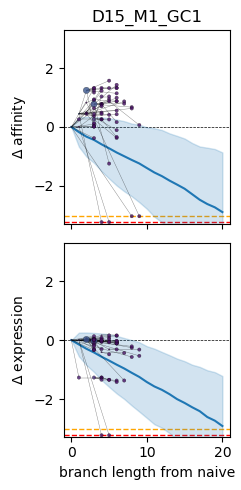

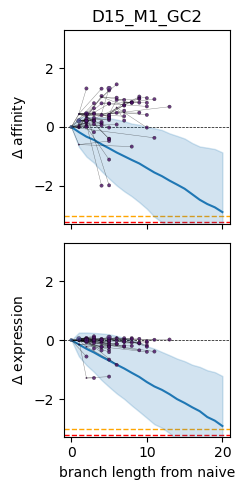

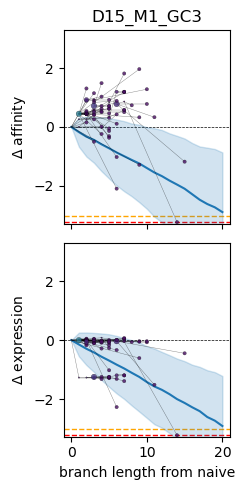

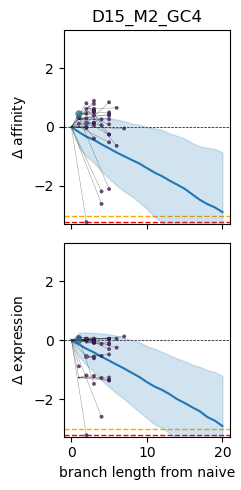

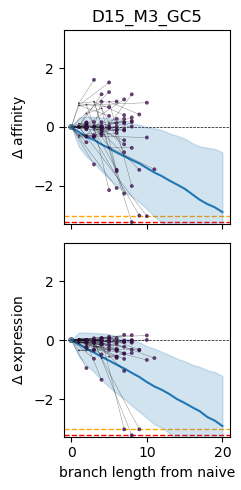

In [14]:
worst_bind = dms_df.delta_bind_CGG.min() # np.nanmin([node.delta_bind_CGG for tree in trees.values() for node in tree.tree.traverse()]) - .1
worst_expr = dms_df.delta_expr.min() # np.nanmin([node.delta_expr for tree in trees.values() for node in tree.tree.traverse()]) - .1

# sim_df_clipped = sim_df.copy(deep=True)
# sim_df_clipped[r"$\Delta$ affinity"] = sim_df_clipped[r"$\Delta$ affinity"].clip(lower=worst_bind)
# sim_df_clipped[r"$\Delta$ expression"] = sim_df_clipped[r"$\Delta$ expression"].clip(lower=worst_expr)

# traj_df = pd.DataFrame()

for j, (gc, tree) in enumerate(trees.items()):

    fig, axes = plt.subplots(2, 1, figsize=(2.5, 5), sharex=True)

    for i, (phenotype, phenotype_label, worst_phenotype) in enumerate(
        zip(("delta_bind", "delta_expr"),
            (r"$\Delta$ affinity", r"$\Delta$ expression"),
            (worst_bind, worst_expr)
            )
            ):

        points = []
        lines = []
        colors = []
        
        for node in tree.tree.traverse():
            node_phenotype = getattr(node, phenotype)
            if node_phenotype < worst_phenotype:
                node_phenotype = worst_phenotype
            elif np.isnan(node_phenotype):
                node_phenotype = worst_phenotype - .2
            points.append((tree.tree.get_distance(node),
                           node_phenotype,
                           1 + 5 * node.abundance,
                           node.REI))
            if node.up is not None:
                parent_phenotype = getattr(node.up, phenotype)
                if parent_phenotype < worst_phenotype:
                    parent_phenotype = worst_phenotype
                elif np.isnan(parent_phenotype):
                    parent_phenotype = worst_phenotype - .2
                lines.append([(tree.tree.get_distance(node.up), parent_phenotype),
                              (tree.tree.get_distance(node), node_phenotype)])
            colors.append(node.REI)

            # row_idx = f"{gc}_{node.name}"
            # traj_df.loc[row_idx, "gc"] = gc
            # traj_df.loc[row_idx, "node"] = node.name
            # traj_df.loc[row_idx, "time"] = metadata.time[gc]
            # traj_df.loc[row_idx, phenotype_label] = node_phenotype
            # traj_df.loc[row_idx, "abundance"] = node.abundance
            # traj_df.loc[row_idx, "REI"] = node.REI

        # sim_lines = []
        # for sim_idx, sim_tree in enumerate(sim_trees[gc]):
        #     for node in sim_tree.traverse():
        #         if node.up is not None:
        #             sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
        #                               (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        # sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i]
        ax.axhline(0, c="k", ls="--", lw=0.5, zorder=1)
        ax.axhline(worst_phenotype, c="orange", ls="--", lw=1, zorder=1)
        ax.axhline(worst_phenotype - 0.2, c="r", ls="--", lw=1, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        # ax.add_collection(sim_lc)
        sns.lineplot(data=sim_df, x="divergence", y=phenotype_label, errorbar='sd', ax=ax, legend=False)
        ax.scatter(*zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4,
                   norm=norm)   
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
        ax.set_ylabel(phenotype_label)
        ax.set_ylim(worst_phenotype - 0.25, -worst_phenotype + 0.25)
    axes[-1].set_xlabel("branch length from naive")
    plt.tight_layout()
    plt.savefig(f"{traj_dir}/{gc}.pdf")
    if j < 5:
        plt.show()
    plt.close()

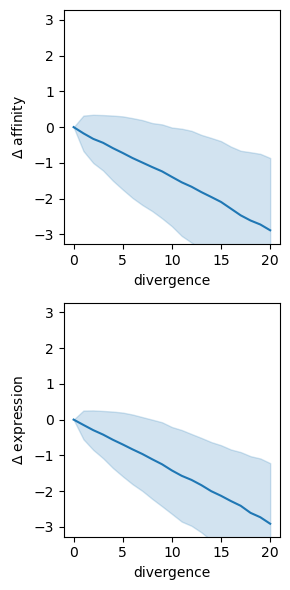

In [15]:
plt.figure(figsize=(3, 6))
plt.subplot(211)
sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ affinity",
             errorbar='sd',
             # units="replicate", estimator=None, lw=1, alpha=0.5,
            )
plt.ylim(worst_bind - 0.25, -worst_bind + 0.25)
plt.subplot(212)
sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ expression",
             errorbar='sd',
             # units="replicate", estimator=None, lw=1, alpha=0.5,
            )
plt.ylim(worst_expr - 0.25, -worst_expr + 0.25)
plt.tight_layout()
plt.savefig(f"{output_dir}/simulated-phenotype-trajectories.pdf")
plt.show()